# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pylab
import statsmodels.api as sm

In [2]:
from io import StringIO
from sklearn.linear_model import LinearRegression
from lmfit.models import LinearModel
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Functions

In [3]:
def plot_style():
    plt.grid()
    plt.minorticks_on()
    plt.grid(which='major', linestyle=':', linewidth='0.2', color='k')
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='k')

    plt.rcParams['xtick.direction'] = 'in' 
    plt.rcParams['ytick.direction'] = 'in' 
    plt.rcParams['xtick.top'] = True 
    plt.rcParams['ytick.right'] = True  
    plt.rc('font', size='20')  
    
    params = {'legend.fontsize': '20',
         'figure.figsize': (10,6),
         'axes.labelsize': '26',
         'axes.titlesize':'26',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'xtick.major.pad':'16',
         'ytick.major.pad':'16'}
    
    pylab.rcParams.update(params)

In [4]:
def add_reference_params(df):
  df["alpha_ref"] = df.alpha[df.LET == 0].iloc[0]
  df["beta_ref"] = df.beta[df.LET == 0].iloc[0]
  df["alpha_ref_err"] = df.alpha_err[df.LET == 0].iloc[0]
  df["beta_ref_err"] = df.beta_err[df.LET == 0].iloc[0]
  return df

# Read data

In [5]:
data_string="""
cell_line	energy	LET	no_points	alpha	alpha_err	beta	beta_err
V79753B	200kV	0	10	0.119	0.017	0.0493	0.0045
V79753B	5.01	7.7	7	0.291	0.024	0.0235	0.0064
V79753B	3.2	11.0	7	0.381	0.027	0.0293	0.0073
V79753B	1.41	20.0	6	0.503	0.028	0.0365	0.0080
C3H10T1	Cobalt	0	5	0.266	0.034	0.0126	0.0082
C3H10T1	3.18	11.0	6	0.482	0.071	0.0192	0.0178
C3H10T1	1.46	19.7	6	0.444	0.052	0.0367	0.0117
C3H10T1	0.87	28.8	5	0.535	0.049	0.0543	0.0129
V79379A	240kV	0	6	0.119	0.020	0.0510	0.0034
V79379A	3.66	10.1	7	0.242	0.039	0.0529	0.0069
V79379A	1.83	17.8	9	0.439	0.055	0.0316	0.0109
V79379A	1.07	27.6	8	0.723	0.025	0.0167	0.0053
HF19	Cs	0	7	0.608	0.043	0.0086	0.0117
HF19	5.04	7.7	6	0.488	0.072	0.0137	0.0181
HF19	1.49	19.5	6	0.541	0.070	0.00000000555	0.0095
HF19	0.88	29.0	7	0.513	0.092	0.0000002498	0.0217
SCC25	Cobalt	0	8	0.525	0.071	0.0412	0.0167
SCC25	5.04	7.7	5	0.342	0.104	0.1078	0.0299
SCC25	1.49	19.5	6	0.835	0.075	0.0094	0.0258
SCC25	0.88	29.0	6	0.799	0.085	0.0000000111	0.0457
SQ20B	Cobalt	0	10	0.091	0.040	0.0230	0.0071
SQ20B	5.04	7.7	6	0.132	0.017	0.0151	0.0037
SQ20B	1.49	19.5	6	0.252	0.022	0.0001413	0.0038
SQ20B	0.88	29.0	7	0.373	0.086	0.0000	0.0192
C1-1	Cobalt	0	7	0.231	0.022	0.0300	0.0067
C1-1	5.04	7.7	6	0.177	0.020	0.0284	0.0070
C1-1	0.88	29.0	5	0.542	0.009	0.000000544	0.0034
DLD1	Cobalt	0	8	0.353	0.080	0.1214	0.0223
DLD1	5.04	7.7	7	0.416	0.075	0.000000247	0.0223
HCT116	Cobalt	0	8	1.347	0.011	0.0313	0.0241
HCT116	5.04	7.7	8	0.341	0.060	0.0577	0.0204

"""

In [6]:
raw_data = pd.read_csv(StringIO(data_string), delimiter='\t')

In [7]:
step1_data = raw_data.groupby('cell_line').apply(add_reference_params)

In [8]:
step2_data = step1_data[step1_data.LET > 0]

In [9]:
fit_data = step2_data.copy()
fit_data['y'] = fit_data.alpha / fit_data.alpha_ref
fit_data['y_centered'] = fit_data.y - 1.0
fit_data['x'] = fit_data.LET / (fit_data.alpha_ref / fit_data.beta_ref)

# Analyze 

In [10]:
eq2_model = LinearModel()

In [11]:
params = eq2_model.make_params()
params['intercept'].vary = False
params['intercept'].value = 1.0
params

name,value,initial value,min,max,vary
slope,1.00000000,None,-inf,inf,True
intercept,1.00000000,None,-inf,inf,False


In [12]:
result = eq2_model.fit( fit_data.y, params, x= fit_data.x)

In [13]:
model = sm.OLS(fit_data.y_centered, fit_data.x)
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:             y_centered   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                              320.0
Date:                Tue, 15 Jun 2021   Prob (F-statistic):                    3.45e-14
Time:                        00:27:46   Log-Likelihood:                         -13.248
No. Observations:                  22   AIC:                                      28.50
Df Residuals:                      21   BIC:                                      29.59
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

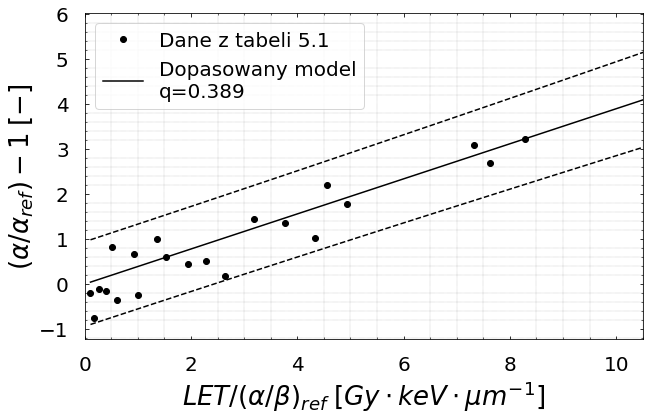

In [19]:
fitted_x_for_plot = np.linspace(start = fit_data.x.min(), stop = fit_data.x.max(), num=100)

prstd, iv_l, iv_u = wls_prediction_std(res, fitted_x_for_plot.reshape(-1,1))


plt.plot(fit_data.x, fit_data.y_centered, 'ko', label="Dane z tabeli 5.1")
plt.plot(fitted_x_for_plot, res.predict(fitted_x_for_plot), 'k', label="Dopasowany model\nq=0.389")
plt.plot(fitted_x_for_plot, iv_u, 'k--')
plt.plot(fitted_x_for_plot, iv_l, 'k--')
plot_style()
plt.legend(loc='best');
plt.xlim(0,10.5)

plt.xlabel(r'$LET  /  ({\alpha / \beta})_{ref} \;[Gy \cdot keV \cdot \mu m^{-1}]$')
plt.ylabel(r'$(\alpha / \alpha_{ref})-1\;[-]$')

tmp=pd.DataFrame(list(zip(fit_data.x, fit_data.y_centered,
                         fitted_x_for_plot, res.predict(fitted_x_for_plot))),
                          columns=['data_x','data_y','model_x','model_y'])

tmp.to_csv("results/figure_5_6")
plt.savefig(fname="results/figure_5_6",dpi= 700)

In [15]:
reg = LinearRegression(fit_intercept=False).fit(fit_data.x.values.reshape(-1, 1), fit_data.y_centered.values.reshape(-1, 1))

In [16]:
 reg.coef_

array([[0.3894271]])